In [1]:
import pandas as pd

In [2]:
# read built dataset
df = pd.read_csv('../../datasets/built_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475428 entries, 0 to 475427
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_name                  475428 non-null  object 
 1   category_name              475428 non-null  object 
 2   date                       475428 non-null  object 
 3   time                       475428 non-null  object 
 4   item_code                  475428 non-null  int64  
 5   quantity_sold_kg           475428 non-null  float64
 6   unit_selling_price_rmb/kg  475428 non-null  float64
 7   sale_or_return             475428 non-null  object 
 8   discount                   475428 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 32.6+ MB


In [3]:
# drop non-dependant columns
df = df.drop(columns=['item_code', 'discount'])
df.sample(2)

,item_name,category_name,date,time,quantity_sold_kg,unit_selling_price_rmb/kg,sale_or_return
111584,chinese cabbage,flower,2021-05-22,11:18:02.186,0.317,12.0,sale
127148,millet pepper,capsicum,2021-06-12,16:03:35.264,0.253,19.8,sale


<Axes: >

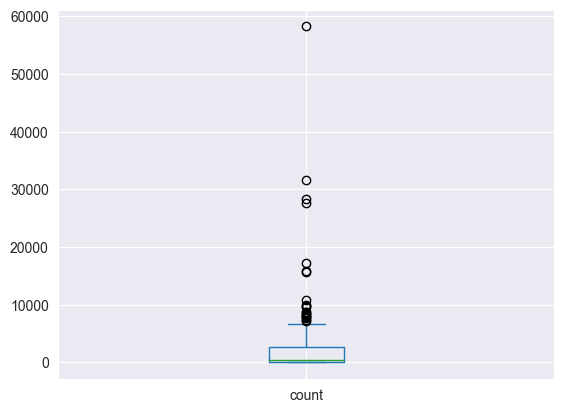

In [4]:
# visualise frequency of selling an item
df['item_name'].value_counts().plot.box()

In [5]:
"""according to the above boxplot there are some items that are sold more than 5000 times. 
    they can be considered as hot selling items and no need to predict a discount on them"""

# drop hot selling items
(df['item_name'].value_counts() > 2000).sum()

53

In [6]:
import numpy as np

In [7]:
# rename top selling items as 'Other'
filt = (df['item_name'].value_counts() > 2000)
df['item_name'] = np.where(filt[df['item_name'].values], 'Other', df['item_name'])
filt = df['item_name'] == 'Other'
df = df.loc[~filt]

df['item_name'].unique().shape[0]

124

<Axes: >

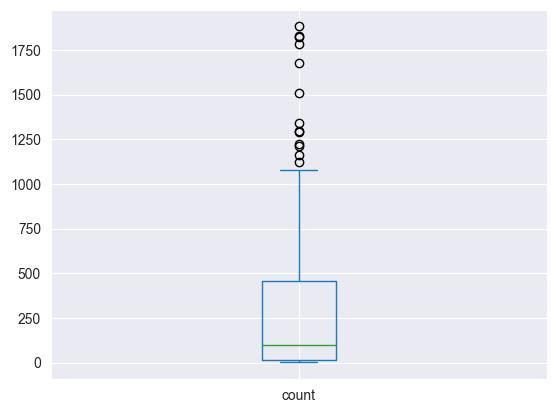

In [8]:
# visualise frequency of selling for rest of items
df['item_name'].value_counts().plot.box()

<Axes: >

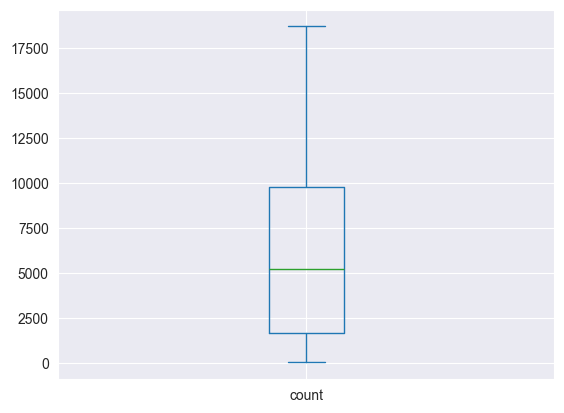

In [9]:
# visualise frequency of selling an category
df['category_name'].value_counts().plot.box()

In [10]:
# check wheather (-) values of sold amount are returned items
(df['quantity_sold_kg'] < 0).sum() == (df['sale_or_return'] == 'return').sum()

True

In [11]:
# remove returned item records
filt = (df['sale_or_return'] == 'return')
df = df.loc[~filt]

df = df.drop(columns=['sale_or_return'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40936 entries, 10 to 475427
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_name                  40936 non-null  object 
 1   category_name              40936 non-null  object 
 2   date                       40936 non-null  object 
 3   time                       40936 non-null  object 
 4   quantity_sold_kg           40936 non-null  float64
 5   unit_selling_price_rmb/kg  40936 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.2+ MB


In [12]:
# check if there are 0 sold amounts
(df['quantity_sold_kg'] == 0).sum()

0

<Axes: >

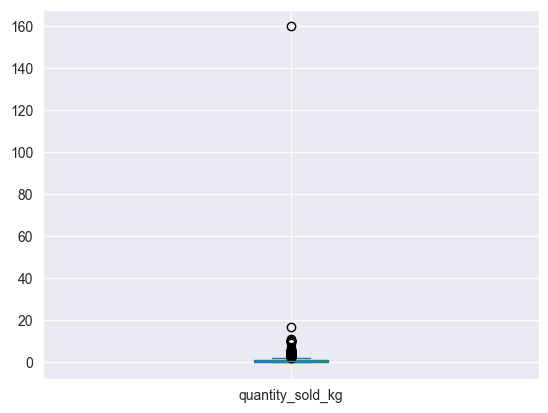

In [13]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

In [14]:
# check the mean of sold amount
np.mean(df['quantity_sold_kg'])

0.6290846443228453

In [15]:
"""according to the above boxplot there are only few purchases that are sold more than 12.5 kg. in general 12.5 kg is very uncommon to buy in a single time and can consider them as outliers. so handle them with mean values."""

# handle outlier with mean values
filt = df['quantity_sold_kg'] > 50
df = df[~filt]

# check the change of mean
np.mean(df['quantity_sold_kg']), df['quantity_sold_kg'].max()

(0.625191376572615, 17.0)

<Axes: >

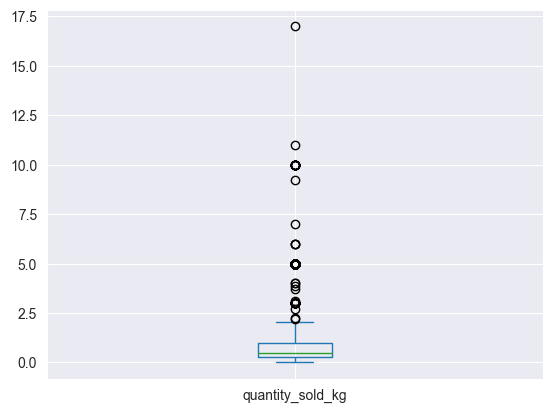

In [16]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

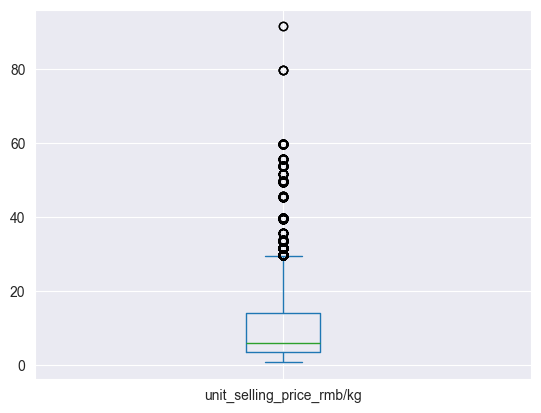

In [17]:
# visualise price
df['unit_selling_price_rmb/kg'].plot.box()

In [18]:
df['time'] = df['time'].str.split(':').str[0].astype(int)

In [19]:
df['time'].head(3)

10     9
35     9
77    10
Name: time, dtype: int64

In [20]:
"""according to the above boxplot there are some items that are sold more than 50 rmb/kg. 
    they can be considered as rare items and by selling very less amount of them aslo can be considered as hot selling. so it is better to not to predict a discount on them"""

price = df[['date', 'item_name', 'category_name', 'time', 'unit_selling_price_rmb/kg']]
df = df.drop(columns=['unit_selling_price_rmb/kg'])
price = price.groupby(['date', 'item_name', 'category_name', 'time']).mean().reset_index()

# group dataset by item name, category and date
df = df.groupby(['date', 'item_name', 'category_name', 'time']).sum().reset_index()
df.shape, price.shape

((24805, 5), (24805, 5))

In [21]:
df = df.merge(price, on=['date', 'item_name', 'category_name', 'time'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24805 entries, 0 to 24804
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       24805 non-null  object 
 1   item_name                  24805 non-null  object 
 2   category_name              24805 non-null  object 
 3   time                       24805 non-null  int64  
 4   quantity_sold_kg           24805 non-null  float64
 5   unit_selling_price_rmb/kg  24805 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [22]:
df.head(3)

,date,item_name,category_name,time,quantity_sold_kg,unit_selling_price_rmb/kg
0,2021-01-01,7 colour pepper,capsicum,12,0.295,18.0
1,2021-01-01,7 colour pepper,capsicum,13,0.378,18.0
2,2021-01-01,7 colour pepper,capsicum,14,0.512,18.0


<Axes: >

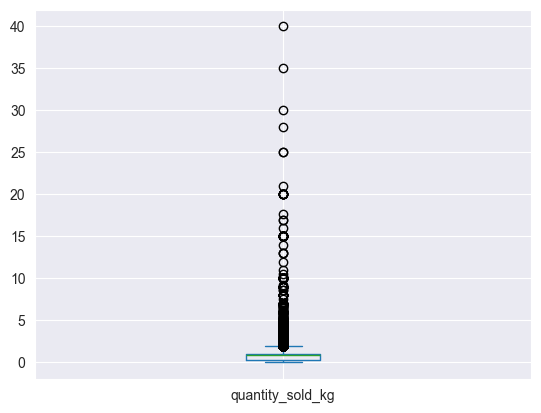

In [23]:
# visualise processed sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

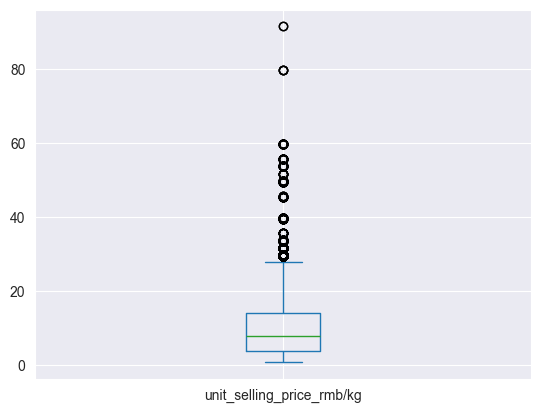

In [24]:
# visualise unit selling price
df['unit_selling_price_rmb/kg'].plot.box()

In [25]:
# view co-relation between price and sold amount
df.loc[:,['unit_selling_price_rmb/kg', 'quantity_sold_kg']].corr()

,unit_selling_price_rmb/kg,quantity_sold_kg
unit_selling_price_rmb/kg,1.000000,-0.315321
quantity_sold_kg,-0.315321,1.000000


<Axes: xlabel='unit_selling_price_rmb/kg', ylabel='quantity_sold_kg'>

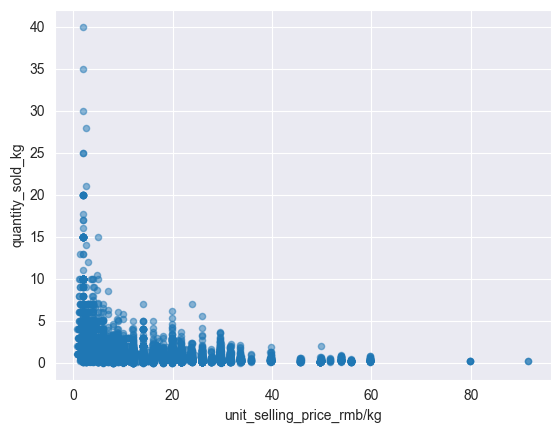

In [26]:
# visualise relation between price and sold amount
df.plot.scatter(x = 'unit_selling_price_rmb/kg', y = 'quantity_sold_kg', alpha = 0.5)

In [27]:
df = df.drop(columns=['date'])

In [28]:
# one hot encoding
df = pd.get_dummies(df)
df.shape

(24805, 133)

In [29]:
df.sample(3)

,time,quantity_sold_kg,unit_selling_price_rmb/kg,item_name_7 colour pepper,item_name_agaricus bisporus,item_name_aihao,item_name_amaranth,item_name_basil,item_name_bell pepper,item_name_big broccoli,...,item_name_yuxingcao,item_name_zhijiang red bolt,item_name_zhimaxiancai,item_name_zhuyecai,category_name_aquatic,category_name_cabbage,category_name_capsicum,category_name_flower,category_name_mushroom,category_name_solanum
16991,18,2.000,1.9,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
23866,10,2.000,3.9,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
11935,16,0.226,8.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [30]:
# save pre-processed dataset
df.to_csv('pre_processed_dataset.csv', index=False)